In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#load dataset
dataset = pd.read_csv('./iris.csv')
dataset.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [3]:
# Overview of Dataset Characteristics
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [4]:
#Summary of N/A Values
dataset.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

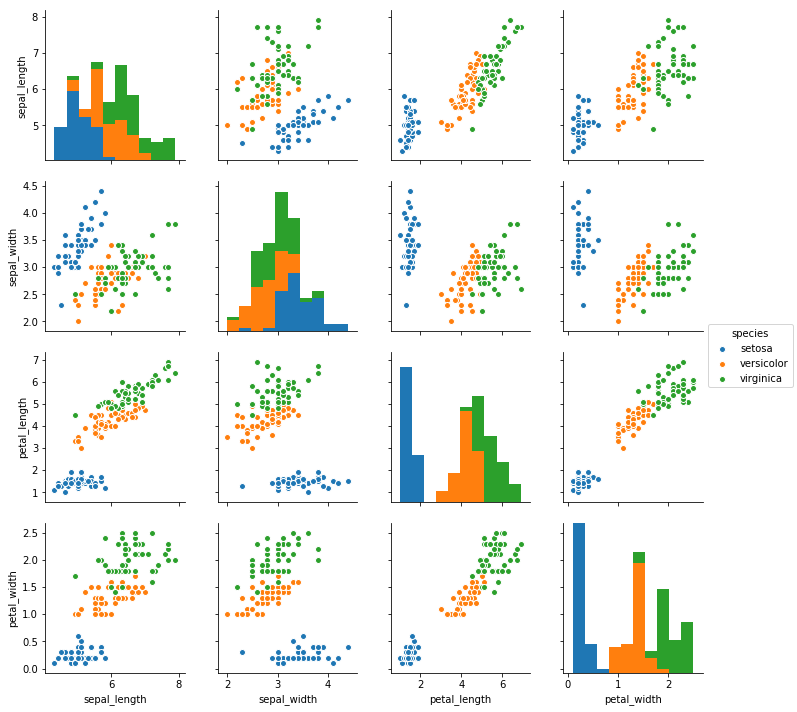

In [5]:
#Visualization of All Variables
pairplot = sns.pairplot(dataset, hue="species")
pairplot

In [6]:
#Review Correlation between Variables
dataset.corr()

sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109369      0.871754     0.817954
sepal_width      -0.109369     1.000000     -0.420516    -0.356544
petal_length      0.871754    -0.420516      1.000000     0.962757
petal_width       0.817954    -0.356544      0.962757     1.000000

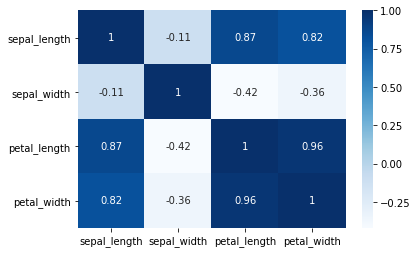

In [7]:
#Visualiztion of Correlations
import seaborn as sns
sns.heatmap(dataset.corr(),annot=True,cmap="Blues")

In [8]:
#Identify Correlated Columns
def correlation(dataset,threshold):
    col_corr=set() # set will contains unique values.
    corr_matrix=dataset.corr() #finding the correlation between columns.
    for i in range(len(corr_matrix.columns)): #number of columns
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking the correlation between columns.
                colName=corr_matrix.columns[i] #getting the column name
                col_corr.add(colName) #adding the correlated column name heigher than threshold value.
    return col_corr #returning set of column names
col=correlation(dataset.drop('species', axis=1),0.8)
print('Correlated columns:',col)    

Correlated columns: {'petal_length', 'petal_width'}


In [9]:
#Create x and y variables
x = dataset.drop('species', axis=1).values
Y = dataset['species'].values

#Scale x variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_2 = sc.fit_transform(x)

In [10]:
#Prepare for Model

#Load Library for Training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Import Model
from sklearn.tree import DecisionTreeClassifier  

In [11]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('clf', DecisionTreeClassifier(random_state=100))])

In [12]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            cv=10,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring='accuracy',
                                                            n_jobs=1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.8, 1.01])
    plt.show()

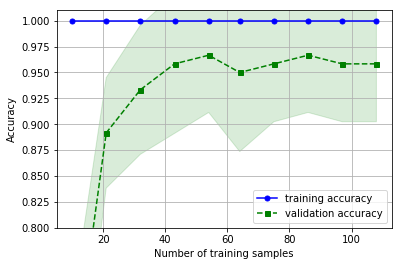

In [13]:
#Plot Learning Curve
plot_learning_curves(pipe_dt)

In [14]:
#Create table to compare MLA metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
pd.set_option('display.max_colwidth', -1) 

# Set grid search params 

max_depth = range(1,100)
param_griddt = {'clf__criterion':['gini','entropy'],
                'clf__max_depth':max_depth}

#Optimize Model
cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
opt_dt = GridSearchCV(estimator=pipe_dt, param_grid=param_griddt,
                       cv=cv2, verbose=0,scoring='accuracy',n_jobs=-1)

# List of pipelines for ease of iteration 
grids = [opt_dt] 

# Dictionary of pipelines and classifier types for ease of reference 
grid_dict = {0:'dt'}

#Create Dataframe for MLA Analysis
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for idx, gs in enumerate(grids):
    
    #Fit grid search
    gs.fit(x_train, y_train)
    
    # Nested CV
    scoresNestedPre = cross_val_score(gs, x_2, Y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoresNestedRec = cross_val_score(gs, x_2, Y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    #Create Dataframe to Compare Models
    MLA_compare.loc[row_index,'Algorithm Name'] = grid_dict[idx]
    MLA_compare.loc[row_index,'Train Accuracy'] = round(gs.best_score_, 2)
    MLA_compare.loc[row_index,'Precision-NestedCV'] = str('{:0.2f} +/- {:0.2f} '.format(np.mean(scoresNestedPre),
                                                                           np.std(scoresNestedPre)))
    MLA_compare.loc[row_index,'Recall-NestedCV'] = str('{:0.2f} +/- {:0.2f} '.format(np.mean(scoresNestedRec),
                                                                           np.std(scoresNestedRec)))
    
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(gs.best_params_)     
    row_index+=1
    
MLA_compare.sort_values(by = ['Precision-NestedCV'], ascending = False, inplace = True)    
MLA_compare

Algorithm Name  Train Accuracy Precision-NestedCV Recall-NestedCV  \
0  dt             0.96            0.96 +/- 0.02      0.96 +/- 0.02    

                                    MLA Parameters  
0  {'clf__criterion': 'gini', 'clf__max_depth': 2}

In [15]:
#Feature Importance - optimized
for name, score in zip(list(dataset),opt_dt.best_estimator_.named_steps['clf'].feature_importances_):
    print(name, round(score,2))

sepal_length 0.0
sepal_width 0.0
petal_length 0.54
petal_width 0.46
